In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving training.csv to training.csv
Saving validation.csv to validation.csv


In [ ]:
train_data = pd.read_csv("training.csv") # Importing the train dataset
test_data = pd.read_csv("test.csv")   # Importing the test dataset
validation_data = pd.read_csv("validation.csv")  # Importing the validation dataset

In [ ]:
print("Train data :\n",train_data.head(),"\n")  # Printing the train dataset
print("Test data :\n",test_data.head(),"\n")   # Printing the test dataset
print("Validation data :\n",validation_data.head(),"\n")  # Printing the validation dataset

Train data :
                                                 text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3 

Test data :
                                                 text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0 

Validation data :
                                                 text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful serva

In [ ]:
print("Train Data shape: ",train_data.shape) #Printing the shape train data
print("Test Data shape: ",test_data.shape) #Printing the shape test data
print("Validation Data shape: ",validation_data.shape) #Printing the shape validation data

Train Data shape:  (16000, 2)
Test Data shape:  (2000, 2)
Validation Data shape:  (2000, 2)


In [ ]:
## Performing the EDA for the training dataset only
print(train_data.info()) # Information about training dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB
None


In [ ]:
print(train_data.describe()) # Describeing the numerical data of training dataset

              label
count  16000.000000
mean       1.565937
std        1.501430
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max        5.000000


In [ ]:
print(train_data.describe(include = 'O')) # Describeing the non-numerical data of training dataset

                                                     text
count                                               16000
unique                                              15969
top     im still not sure why reilly feels the need to...
freq                                                    2


In [ ]:
train_data['label'].value_counts() # Counting the number of positive and negative sentiments of the training dataset

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


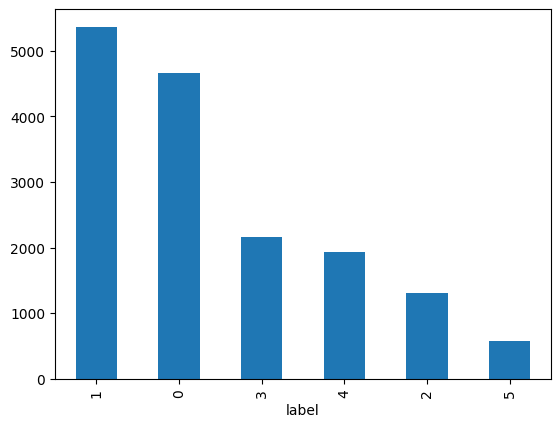

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar') # Plotting the bar plot for visualizing the countness of positive and negative labels
plt.show()

In [ ]:
print("The Null value rows present in the trianing dataset is : ",train_data.isna().sum())    # Printing the null value present in the training dataset
print("The Duplicate rows present in the training dataset is : ",train_data.duplicated().sum())   # Printing the duplicated value present in the training dataset

The Null value rows present in the trianing dataset is :  text     0
label    0
dtype: int64
The Duplicate rows present in the training dataset is :  1


In [ ]:
train_data.drop_duplicates(keep = 'first',inplace=True) # Dropping the duplicated values and keeping the first value in the dataset

In [ ]:
print("Now the Duplicate rows present in the training dataset is : ",train_data.duplicated().sum()) # After Dropping now the duplicated values are zero
print("Now the shape of the training dataset is ",train_data.shape) # After dropping the duplicates the rows of the training data reduce

Now the Duplicate rows present in the training dataset is :  0
Now the shape of the training dataset is  (15999, 2)


In [ ]:
## Perfoming the text preprocessing

nltk.download('stopwords')  # Downloading all the stopwords from the nltk library
pattern = re.compile('<.*?>')  # Pattern for removing the HTML tags
punctuation = string.punctuation   # Extracting all punctuation from the string library
ps = PorterStemmer()  # Creating a PorterStemmer object for the stemming purpose
tokenizer = Tokenizer() # Creating a Tokenizer object for representing the text into numeric form

def text_preprocess(text):

  text = re.sub(pattern,'',text)  # Removing the HTML tags using re library

  text = text.lower()  # Lower case all the character present in the text

  text = text.translate(str.maketrans('','',punctuation))   # Removing all the punctuation from the text

  text = text.split()    # word tokenize the text

  text = [ps.stem(word) for word in text if word not in stopwords.words('english')]  # Removing the stopwords from the text and stem each word

  return ' '.join(text)  # Join each word for the formation of clear text in string form

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
processed_train_data = [text_preprocess(words) for words in train_data['text']]   # Applying the text pre-processing fuction to the text column of train dataset
processed_validation_data = [text_preprocess(words) for words in validation_data['text']]  # Applying the text pre-processing fuction to the text column of validation dataset
processed_test_data = [text_preprocess(words) for words in test_data['text']]   # Applying the text pre-processing fuction to the text column of test dataset

In [ ]:
# Putting all the processed text of train data into a whole text. Then fit this whole text into the tokenizer for word embedding.

whole_text = ''

for i in processed_train_data:
  whole_text = whole_text + i


tokenizer.fit_on_texts([whole_text])
print(len(tokenizer.word_index))   # Printing the vocab size or the number of words present in the train data text. This is used as hyperparameter for the embedding layer.

20360


In [ ]:
# In this cell the train processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_train_sequences = []

for i in processed_train_data:
  x_train_sequences.append(tokenizer.texts_to_sequences([i])[0])  # Each processed text is converted into sequences


x_train_padseq = pad_sequences(x_train_sequences,maxlen = 50, padding = 'post')  # Each sequences are padded to have equal size.

x_train = np.array(x_train_padseq)
y_train = np.array(to_categorical(train_data['label']))

In [ ]:
# In this cell the validation processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_validation_sequences = []

for i in processed_validation_data:
  x_validation_sequences.append(tokenizer.texts_to_sequences([i])[0])    # Each processed text is converted into sequences


x_validation_padseq = pad_sequences(x_validation_sequences,maxlen = 50, padding = 'post')    # Each sequences are padded to have equal size.

x_validation = np.array(x_validation_padseq)
y_validation = np.array(to_categorical(validation_data['label']))

In [ ]:
# In this cell the test processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_test_sequences = []

for i in processed_test_data:
  x_test_sequences.append(tokenizer.texts_to_sequences([i])[0])     # Each processed text is converted into sequences


x_test_padseq = pad_sequences(x_test_sequences,maxlen = 50, padding = 'post')    # Each sequences are padded to have equal size.

x_test = np.array(x_test_padseq)
y_test = np.array(test_data['label'])

In [ ]:
## Defining the hyperparameter of the embedding layer

vocab_size = 20360   # vocabulary size of the tokenizer
dim = 50             # Number of dense vector dimension required for the output
sent_length = 50    # The length of each sequence

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# Hyperparameters
vocab_size = 20360   # Vocabulary size
dim = 50             # Embedding dimension
sent_length = 50     # Max sequence length

# Define the model
bidirectional_lstm_model = Sequential([
    Embedding(vocab_size, dim, input_length=sent_length),
    Bidirectional(LSTM(100)),
    Dense(6, activation='softmax')
])

# Compile the model
bidirectional_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build model manually (optional)
bidirectional_lstm_model.build((None, sent_length))

# Print summary
bidirectional_lstm_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 50, 50)              │       1,018,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 200)                 │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           1,206 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,006 (4.35 MB)

 Trainable params: 1,140,006 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
bidirectional_lstm_model_history = bidirectional_lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 99ms/step - accuracy: 0.4169 - loss: 1.4630 - val_accuracy: 0.7550 - val_loss: 0.7080
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.8341 - loss: 0.4950 - val_accuracy: 0.8565 - val_loss: 0.4408
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 96ms/step - accuracy: 0.9249 - loss: 0.2199 - val_accuracy: 0.8690 - val_loss: 0.3911
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 91ms/step - accuracy: 0.9579 - loss: 0.1290 - val_accuracy: 0.8790 - val_loss: 0.3674
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 95ms/step - accuracy: 0.9669 - loss: 0.0947 - val_accuracy: 0.8825 - val_loss: 0.3767


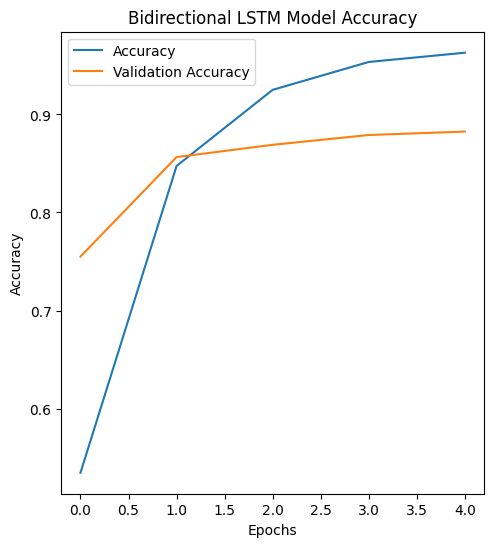

In [ ]:
# Setting the figure size of the plot
plt.figure(figsize=(12,6))


# Plotting the accuracy plot of Bidirectional LSTM model
plt.subplot(1,2,1)
plt.title("Bidirectional LSTM Model Accuracy")
plt.plot(bidirectional_lstm_model_history.history['accuracy'],label='Accuracy')
plt.plot(bidirectional_lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
y_pred_bilstm = bidirectional_lstm_model.predict(x_test)
y_pred_bilstm = np.array([np.argmax(x) for x in y_pred_bilstm])

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


In [ ]:
result_bilstm = {
    "Model Name": ["Bidirectional LSTM"],
    "Accuracy Score": [accuracy_score(y_test, y_pred_bilstm)],
    "F1 Score (macro)": [f1_score(y_test, y_pred_bilstm, average='macro')],
    "Recall Score (macro)": [recall_score(y_test, y_pred_bilstm, average='macro')],
    "Precision Score (macro)": [precision_score(y_test, y_pred_bilstm, average='macro')],
    "F1 Score (micro)": [f1_score(y_test, y_pred_bilstm, average='micro')],
    "Recall Score (micro)": [recall_score(y_test, y_pred_bilstm, average='micro')],
    "Precision Score (micro)": [precision_score(y_test, y_pred_bilstm, average='micro')],
}

result_bilstm_df = pd.DataFrame(result_bilstm)

# Save the results to an Excel file
result_bilstm_df.to_excel("BiLSTM_Model_Report.xlsx", index=False)

# Display the results
display(result_bilstm_df)


,Model Name,Accuracy Score,F1 Score (macro),Recall Score (macro),Precision Score (macro),F1 Score (micro),Recall Score (micro),Precision Score (micro)
0,Bidirectional LSTM,0.882,0.834294,0.826933,0.843626,0.882,0.882,0.882


In [ ]:
def predict_emotion_of_text(text):
    processed_text = text_preprocess(text)  # Preprocess input text
    text_to_sequence = tokenizer.texts_to_sequences([processed_text])[0]
    padded_sequence = pad_sequences([text_to_sequence], maxlen=50, padding='post')

    # Predict using the Bidirectional LSTM model
    prediction = bidirectional_lstm_model.predict(padded_sequence)[0]

    # Emotion classes
    classes = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

    print("Input:", text)
    print("Predicted Emotion:", classes[np.argmax(prediction)])
    print("\n")


In [ ]:
# Testing our model output with my own custom data

predict_emotion_of_text("Today is a bad day for me")
predict_emotion_of_text("she always gets angry if she doesn't get her own way")
predict_emotion_of_text("I love myself")
predict_emotion_of_text("What a beautiful day ")
predict_emotion_of_text("That horror movie is so scary")
predict_emotion_of_text("Wow! what a lovely surprise")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Input: Today is a bad day for me
Predicted Emotion: sadness


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Input: she always gets angry if she doesn't get her own way
Predicted Emotion: anger


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Input: I love myself
Predicted Emotion: love


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Input: What a beautiful day 
Predicted Emotion: anger


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Input: That horror movie is so scary
Predicted Emotion: anger


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Input: Wow! what a lovely surprise
Predicted Emotion: surprise


